# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [2]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [3]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [4]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [5]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [6]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [7]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [8]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

## Plot the outputs

Create a few plots of the output.

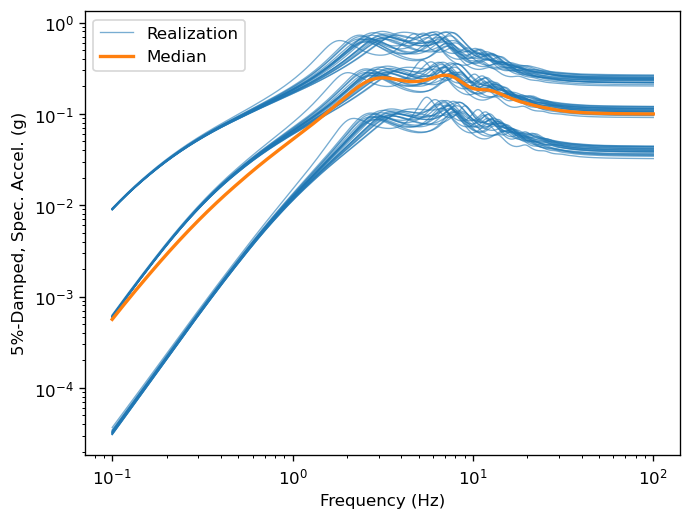

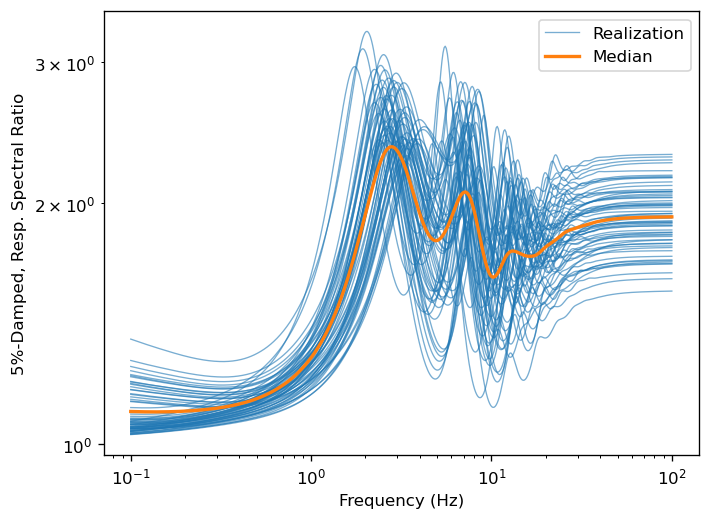

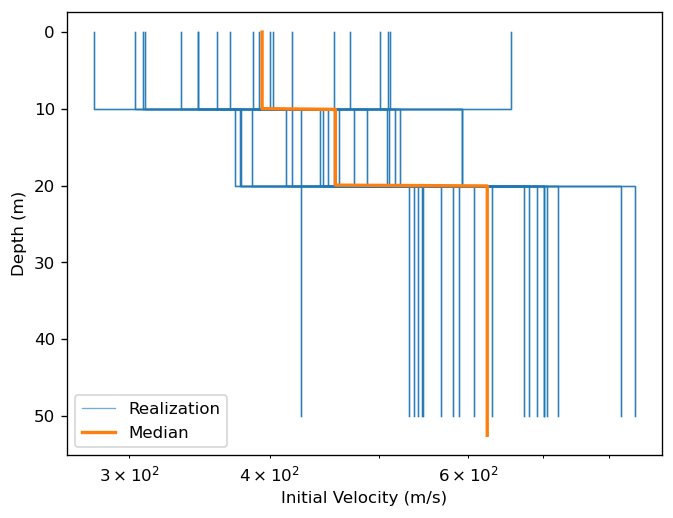

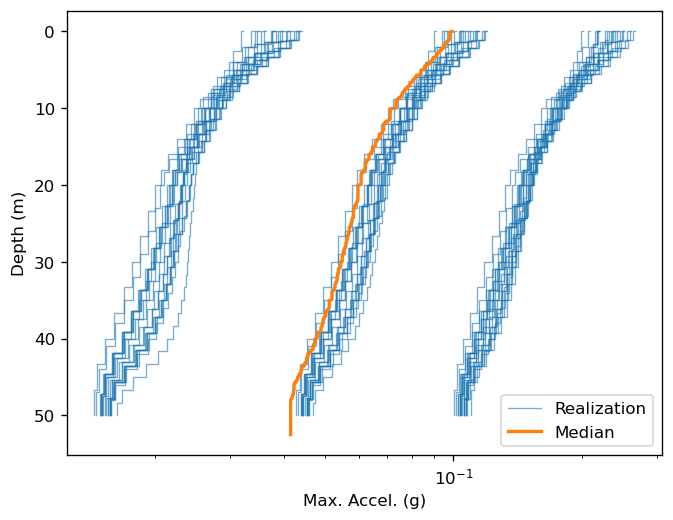

In [9]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [10]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.187886  1.063375  1.039357  1.179433  1.060336  1.037298   
0.101394    1.187251  1.063331  1.039665  1.178815  1.060295  1.037590   
0.102807    1.186619  1.063292  1.039975  1.178199  1.060259  1.037886   
0.104240    1.185989  1.063258  1.040289  1.177586  1.060227  1.038185   
0.105693    1.185362  1.063229  1.040607  1.176975  1.060201  1.038487   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.873235  1.799618  1.698237  1.678340  1.636310  1.552305   
95.932095   1.873302  1.799679  1.698315  1.678427  1.636390  1.552395   
97.269336   1.873367  1.799738  1.698390  1.678512  1.636467  1.552483   
98.625218   1.873429  1.799796  1.698463  1.678594  1.636542  1.552568   
100.000000  1.873490  1.799851  1.698533  1.678674  1.636614  1.552650   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.221302  1.075894  1.048748  1.169058  ...  1.037027  1.250147   
0.101394    1.220569  1.075834  1.049121  1.168553  ...  1.037318  1.249231   
0.102807    1.219838  1.075780  1.049497  1.168050  ...  1.037612  1.248318   
0.104240    1.219109  1.075731  1.049877  1.167548  ...  1.037909  1.247408   
0.105693    1.218384  1.075687  1.050261  1.167049  ...  1.038210  1.246501   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   2.283180  2.150574  2.013400  2.152198  ...  1.882372  2.103115   
95.932095   2.283258  2.150650  2.013507  2.152244  ...  1.882444  2.103201   
97.269336   2.283333  2.150723  2.013611  2.152288  ...  1.882515  2.103283   
98.625218   2.283407  2.150794  2.013712  2.152331  ...  1.882583  2.103364   
100.000000  2.283478  2.150862  2.013809  2.152372  ...  1.882648  2.103441   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.083281  1.052534  1.153547  1.052644  1.032755  1.131857   
0.101394    1.083206  1.052932  1.153099  1.052618  1.033015  1.131529   
0.102807    1.083136  1.053334  1.152651  1.052596  1.033279  1.131202   
0.104240    1.083072  1.053741  1.152206  1.052579  1.033545  1.130877   
0.105693    1.083014  1.054151  1.151762  1.052566  1.033814  1.130553   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.994545  1.836652  2.030459  1.928989  1.850662  2.194724   
95.932095   1.994631  1.836763  2.030500  1.929020  1.850712  2.194743   
97.269336   1.994715  1.836869  2.030540  1.929050  1.850761  2.194762   
98.625218   1.994795  1.836973  2.030578  1.929079  1.850807  2.194780   
100.000000  1.994873  1.837073  2.030616  1.929107  1.850853  2.194798   

                                
                  m1        m2  
0.100000    1.046033  1.029188  
0.101394    1.046018  1.029423  
0.102807    1.046007  1.029661  
0.104240    1.045999  1.029901  
0.105693    1.045996  1.030144  
...              ...       ...  
94.613238   2.067271  1.999991  
95.932095   2.067281  2.000028  
97.269336   2.067291  2.000064  
98.625218   2.067300  2.000099  
100.000000  2.067309  2.000132  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [11]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.reset_index().melt(id_vars="freq")
df

,freq,profile,motion,value
0,0.100000,p0,m0,1.187886
1,0.101394,p0,m0,1.187251
2,0.102807,p0,m0,1.186619
3,0.104240,p0,m0,1.185989
4,0.105693,p0,m0,1.185362
...,...,...,...,...
29995,94.613238,p19,m2,1.999991
29996,95.932095,p19,m2,2.000028
29997,97.269336,p19,m2,2.000064
29998,98.625218,p19,m2,2.000099


In [12]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.194237  0.043100
           m1      1.065686  0.015043
           m2      1.041169  0.009723
0.101394   m0      1.193592  0.042915
           m1      1.065639  0.015019
...                     ...       ...
98.625218  m1      1.927893  0.077434
           m2      1.814888  0.074419
100.000000 m0      2.028527  0.087896
           m1      1.927947  0.077433
           m2      1.814961  0.074416

[1500 rows x 2 columns]

In [13]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.043100  1.194237  0.015043  1.065686  0.009723  1.041169
0.101394    0.042915  1.193592  0.015019  1.065639  0.009787  1.041488
0.102807    0.042730  1.192948  0.014996  1.065596  0.009852  1.041810
0.104240    0.042546  1.192308  0.014973  1.065559  0.009917  1.042136
0.105693    0.042363  1.191669  0.014951  1.065527  0.009983  1.042465
...              ...       ...       ...       ...       ...       ...
94.613238   0.087906  2.028285  0.077437  1.927723  0.074427  1.814655
95.932095   0.087904  2.028348  0.077436  1.927782  0.074425  1.814735
97.269336   0.087901  2.028410  0.077435  1.927838  0.074422  1.814813
98.625218   0.087899  2.028469  0.077434  1.927893  0.074419  1.814888
100.000000  0.087896  2.028527  0.077433  1.927947  0.074416  1.814961

[500 rows x 6 columns]

Access the properties of each motion like:

In [14]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.043100,1.194237
0.101394,0.042915,1.193592
0.102807,0.042730,1.192948
0.104240,0.042546,1.192308
0.105693,0.042363,1.191669
...,...,...
94.613238,0.087906,2.028285
95.932095,0.087904,2.028348
97.269336,0.087901,2.028410


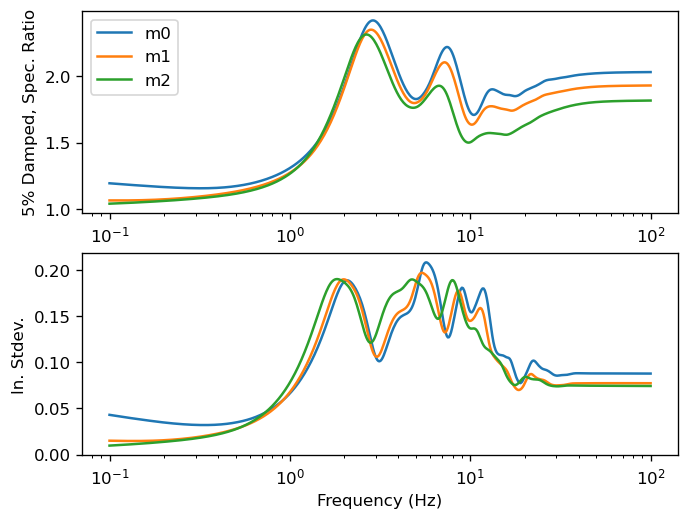

In [15]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.groupby(level=0, axis=1):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.index, g[(name, key)], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;